In [1]:
import sys
if 'google.colab' in sys.modules:
    import os

    os.system('apt-get install -y xvfb')
    os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
    os.system('apt-get install -y python-opengl ffmpeg')
    os.system('pip install pyglet==1.2.4')

# launch XVFB if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


### Let's make a TRPO!

In this notebook we will write the code of the one Trust Region Policy Optimization.
As usually, it contains a few different parts which we are going to reproduce.



In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import gym

env = gym.make("Acrobot-v1")
env.reset()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box(6,)
Action Space Discrete(3)


/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


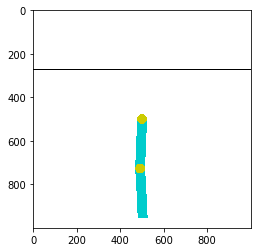

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(env.render('rgb_array'))

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method. 

This essentially means we're actually training a stochastic policy $ \pi_\theta(a|s) $. 

And yes, it's gonna be a neural network. So let's start by defining one.

In [7]:
class TRPOAgent(nn.Module):
    def __init__(self, state_shape, n_actions, hidden_size=32):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple: 
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        nn.Module.__init__(self)

        
        self.model = nn.Sequential(
            nn.Linear(state_shape[0], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.LogSoftmax()
            
        )

    def forward(self, states):
        """
        takes agent's observation (Variable), returns log-probabilities (Variable)
        :param state_t: a batch of states, shape = [batch_size, state_shape]
        """

        # Use your network to compute log_probs for given state
        log_probs = self.model(states)
        return log_probs

    def get_log_probs(self, states):
        '''
        Log-probs for training
        '''

        return self.forward(states)

    def get_probs(self, states):
        '''
        Probs for interaction
        '''

        return torch.exp(self.forward(states))

    def act(self, obs, sample=True):
        '''
        Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
        :param: obs - single observation vector
        :param sample: if True, samples from \pi, otherwise takes most likely action
        :returns: action (single integer) and probabilities for all actions
        '''

        probs = self.get_probs(Variable(torch.FloatTensor([obs]))).data.numpy()

        if sample:
            action = int(np.random.choice(n_actions, p=probs[0]))
        else:
            action = int(np.argmax(probs))

        return action, probs[0]


agent = TRPOAgent(observation_shape, n_actions)

In [8]:
# Check if log-probabilities satisfies all the requirements
log_probs = agent.get_log_probs(Variable(torch.FloatTensor([env.reset()])))
assert isinstance(
    log_probs, Variable) and log_probs.requires_grad, "qvalues must be a torch variable with grad"
assert len(
    log_probs.shape) == 2 and log_probs.shape[0] == 1 and log_probs.shape[1] == n_actions
sums = torch.sum(torch.exp(log_probs), dim=1)
assert (0.999 < sums).all() and (1.001 > sums).all()

# Demo use
print("sampled:", [agent.act(env.reset()) for _ in range(5)])
print("greedy:", [agent.act(env.reset(), sample=False) for _ in range(5)])

sampled: [(0, array([0.31424966, 0.33459982, 0.3511505 ], dtype=float32)), (2, array([0.3157406 , 0.33410597, 0.35015345], dtype=float32)), (2, array([0.31521416, 0.33570856, 0.34907728], dtype=float32)), (1, array([0.31578445, 0.33468956, 0.34952602], dtype=float32)), (1, array([0.31485352, 0.33348814, 0.35165828], dtype=float32))]
greedy: [(2, array([0.31340396, 0.33272216, 0.35387385], dtype=float32)), (2, array([0.3124737, 0.3336543, 0.353872 ], dtype=float32)), (2, array([0.31213105, 0.33466184, 0.35320702], dtype=float32)), (2, array([0.31424883, 0.33490282, 0.3508484 ], dtype=float32)), (2, array([0.31318882, 0.3343707 , 0.35244048], dtype=float32))]


/Users/alex-kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


#### Flat parameters operations

We are going to use it

In [9]:
def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))

    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size

Compute cummulative reward just like you did in vanilla REINFORCE

In [10]:
import scipy.signal


def get_cummulative_returns(r, gamma=1):
    """
    Computes cummulative discounted rewards given immediate rewards
    G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
    Also known as R(s,a).
    """
    r = np.array(r)
    assert r.ndim >= 1
    return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]

In [11]:
# simple demo on rewards [0,0,1,0,0,1]
get_cummulative_returns([0, 0, 1, 0, 0, 1], gamma=0.9)

array([1.40049, 1.5561 , 1.729  , 0.81   , 0.9    , 1.     ])

**Rollout**

In [12]:
def rollout(env, agent, max_pathlength=2500, n_timesteps=50000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0
    while total_timesteps < n_timesteps:
        obervations, actions, rewards, action_probs = [], [], [], []
        obervation = env.reset()
        for _ in range(max_pathlength):
            action, policy = agent.act(obervation)
            obervations.append(obervation)
            actions.append(action)
            action_probs.append(policy)
            obervation, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1
            if done or total_timesteps == n_timesteps:
                path = {"observations": np.array(obervations),
                        "policy": np.array(action_probs),
                        "actions": np.array(actions),
                        "rewards": np.array(rewards),
                        "cumulative_returns": get_cummulative_returns(rewards),
                        }
                paths.append(path)
                break
    return paths

In [13]:
paths = rollout(env, agent, max_pathlength=5, n_timesteps=100)
print(paths[-1])
assert (paths[0]['policy'].shape == (5, n_actions))
assert (paths[0]['cumulative_returns'].shape == (5,))
assert (paths[0]['rewards'].shape == (5,))
assert (paths[0]['observations'].shape == (5,)+observation_shape)
assert (paths[0]['actions'].shape == (5,))
print('It\'s ok')

{'observations': array([[ 9.96041793e-01, -8.88861422e-02,  9.99902560e-01,
        -1.39596265e-02, -9.76232592e-02,  4.39685655e-02],
       [ 9.95286617e-01, -9.69770628e-02,  9.99917629e-01,
        -1.28348880e-02,  1.79116500e-02, -3.39707913e-02],
       [ 9.95446875e-01, -9.53179934e-02,  9.99972544e-01,
         7.41023409e-03, -8.75568790e-04,  2.33001925e-01],
       [ 9.97525822e-01, -7.03010282e-02,  9.99963385e-01,
         8.55731971e-03,  2.46532867e-01, -2.17267865e-01],
       [ 9.99998996e-01, -1.41680985e-03,  9.97306125e-01,
        -7.33518376e-02,  4.26061745e-01, -5.77011151e-01]]), 'policy': array([[0.31489557, 0.3352713 , 0.34983316],
       [0.3160735 , 0.33387834, 0.3500482 ],
       [0.31513685, 0.33393684, 0.35092637],
       [0.3179372 , 0.33063775, 0.3514251 ],
       [0.32235065, 0.3290942 , 0.34855515]], dtype=float32), 'actions': array([1, 2, 0, 0, 0]), 'rewards': array([-1., -1., -1., -1., -1.]), 'cumulative_returns': array([-5., -4., -3., -2., -1.])

/Users/alex-kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Step 3: Auxiliary functions

Now let's define the loss functions and something else for actual TRPO training.

The surrogate reward should be
$$J_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}A_{\theta_{old}(s_i, a_i)}$$

For simplicity, let's use cummulative returns instead of advantage for now:
$$J'_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}G_{\theta_{old}(s_i, a_i)}$$

Or alternatively, minimize the surrogate loss:
$$ L_{surr} = - J'_{surr} $$  


In [15]:
def get_loss(agent, observations, actions, cummulative_returns, old_probs):
    """
    Computes TRPO objective
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cummulative_returns - batch of cummulative returns
    :param: old_probs - batch of probabilities computed by old network
    :returns: scalar value of the objective function
    """
    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    probs_for_actions = probs_all[torch.arange(
        0, batch_size, out=torch.LongTensor()), actions]
    old_probs_for_actions = old_probs[torch.arange(
        0, batch_size, out=torch.LongTensor()), actions]

    # Compute surrogate loss, aka importance-sampled policy gradient
    Loss = -torch.mean(probs_for_actions / old_probs_for_actions * cummulative_returns)

    assert Loss.shape == torch.Size([])
    return Loss

We can ascend these gradients as long as our $pi_\theta(a|s)$ satisfies the constraint
$$E_{s,\pi_{\Theta_{t}}}\Big[KL(\pi(\Theta_{t}, s) \:||\:\pi(\Theta_{t+1}, s))\Big]< \alpha$$


where

$$KL(p||q) = E _p log({p \over q})$$

In [18]:
A = torch.tensor(np.arange(6).reshape((2, 3)))
A.sum(dim=1)

tensor([ 3, 12])

In [21]:
def get_kl(agent, observations, actions, cummulative_returns, old_probs_all):
    """
    Computes KL-divergence between network policy and old policy
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cummulative_returns - batch of cummulative returns (we don't need it actually)
    :param: old_probs - batch of probabilities computed by old network
    :returns: scalar value of the KL-divergence
    """
    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    # Compute Kullback-Leibler divergence (see formula above)
    # Note: you need to sum KL and entropy over all actions, not just the ones agent took
    old_log_probs_all = torch.log(old_probs_all+1e-10)

    kl = torch.mean(torch.sum(old_probs_all * (old_log_probs_all - log_probs_all), dim=1))

    assert kl.shape == torch.Size([])
    assert (kl > -0.0001).all() and (kl < 10000).all()
    return kl

In [22]:
def get_entropy(agent, observations):
    """
    Computes entropy of the network policy 
    :param: observations - batch of observations
    :returns: scalar value of the entropy
    """

    observations = Variable(torch.FloatTensor(observations))

    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    entropy = torch.sum(-probs_all * log_probs_all) / batch_size

    assert entropy.shape == torch.Size([])
    return entropy

**Linear search**

TRPO in its core involves ascending surrogate policy gradient constrained by KL divergence. 

In order to enforce this constraint, we're gonna use linesearch. You can find out more about it [here](https://en.wikipedia.org/wiki/Linear_search)

In [27]:
def linesearch(f, x, fullstep, max_kl):
    """
    Linesearch finds the best parameters of neural networks in the direction of fullstep contrainted by KL divergence.
    :param: f - function that returns loss, kl and arbitrary third component.
    :param: x - old parameters of neural network.
    :param: fullstep - direction in which we make search.
    :param: max_kl - constraint of KL divergence.
    :returns:
    """
    max_backtracks = 10
    loss, _, = f(x)
    for stepfrac in .5**np.arange(max_backtracks):
        xnew = x + stepfrac * fullstep
        new_loss, kl = f(xnew)
        actual_improve = new_loss - loss
        if kl.data.numpy() <= max_kl and actual_improve.data.numpy() < 0:
            x = xnew
            loss = new_loss
    return x

**Conjugate gradients**

Since TRPO includes contrainted optimization, we will need to solve Ax=b using conjugate gradients.

In general, CG is an algorithm that solves Ax=b where A is positive-defined. A is Hessian matrix so A is positive-defined. You can find out more about them [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

In [28]:
from numpy.linalg import inv


def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    p = b.clone()
    r = b.clone()
    x = torch.zeros(b.size())
    rdotr = torch.sum(r*r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (torch.sum(p*z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = torch.sum(r*r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

In [29]:
# This code validates conjugate gradients
A = np.random.rand(8, 8)
A = np.matmul(np.transpose(A), A)


def f_Ax(x):
    return torch.matmul(torch.FloatTensor(A), x.view((-1, 1))).view(-1)


b = np.random.rand(8)

w = np.matmul(np.matmul(inv(np.matmul(np.transpose(A), A)),
                        np.transpose(A)), b.reshape((-1, 1))).reshape(-1)
print(w)
print(conjugate_gradient(f_Ax, torch.FloatTensor(b)).numpy())

[ 1.14573248  0.53796426 -1.51234943 -0.05174622 -2.13258298  2.78361983
 -1.04248589  1.96037527]
[ 1.1461927   0.53743964 -1.5073658  -0.05307736 -2.133082    2.779952
 -1.0402566   1.9577781 ]


### Step 4: training
In this section we construct the whole update step function.

In [30]:
def update_step(agent, observations, actions, cummulative_returns, old_probs, max_kl):
    """
    This function does the TRPO update step
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cummulative_returns - batch of cummulative returns
    :param: old_probs - batch of probabilities computed by old network
    :param: max_kl - controls how big KL divergence may be between old and new policy every step.
    :returns: KL between new and old policies and the value of the loss function.
    """

    # Here we prepare the information
    observations = Variable(torch.FloatTensor(observations))
    actions = torch.LongTensor(actions)
    cummulative_returns = Variable(torch.FloatTensor(cummulative_returns))
    old_probs = Variable(torch.FloatTensor(old_probs))

    # Here we compute gradient of the loss function
    loss = get_loss(agent, observations, actions,
                    cummulative_returns, old_probs)
    grads = torch.autograd.grad(loss, agent.parameters())
    loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

    def Fvp(v):
        # Here we compute Fx to do solve Fx = g using conjugate gradients
        # We actually do here a couple of tricks to compute it efficiently

        kl = get_kl(agent, observations, actions,
                    cummulative_returns, old_probs)

        grads = torch.autograd.grad(kl, agent.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

        kl_v = (flat_grad_kl * Variable(v)).sum()
        grads = torch.autograd.grad(kl_v, agent.parameters())
        flat_grad_grad_kl = torch.cat(
            [grad.contiguous().view(-1) for grad in grads]).data

        return flat_grad_grad_kl + v * 0.1

    # Here we solveolve Fx = g system using conjugate gradients
    stepdir = conjugate_gradient(Fvp, -loss_grad, 10)

    # Here we compute the initial vector to do linear search
    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)

    # Here we get the start point
    prev_params = get_flat_params_from(agent)

    def get_loss_kl(params):
        # Helper for linear search
        set_flat_params_to(agent, params)
        return [get_loss(agent, observations, actions, cummulative_returns, old_probs),
                get_kl(agent, observations, actions, cummulative_returns, old_probs)]

    # Here we find our new parameters
    new_params = linesearch(get_loss_kl, prev_params, fullstep, max_kl)

    # And we set it to our network
    set_flat_params_to(agent, new_params)

    return get_loss_kl(new_params)

##### Step 5: Main TRPO loop

Here we will train our network!

In [31]:
import time
from itertools import count
from collections import OrderedDict

# this is hyperparameter of TRPO. It controls how big KL divergence may be between old and new policy every step.
max_kl = 0.01
numeptotal = 0  # this is number of episodes that we played.

start_time = time.time()

for i in count(1):

    print("\n********** Iteration %i ************" % i)

    # Generating paths.
    print("Rollout")
    paths = rollout(env, agent)
    print("Made rollout")

    # Updating policy.
    observations = np.concatenate([path["observations"] for path in paths])
    actions = np.concatenate([path["actions"] for path in paths])
    returns = np.concatenate([path["cumulative_returns"] for path in paths])
    old_probs = np.concatenate([path["policy"] for path in paths])

    loss, kl = update_step(agent, observations, actions,
                           returns, old_probs, max_kl)

    # Report current progress
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = OrderedDict()
    numeptotal += len(episode_rewards)
    stats["Total number of episodes"] = numeptotal
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl.data.numpy()
    stats["Entropy"] = get_entropy(agent, observations).data.numpy()
    stats["Surrogate loss"] = loss.data.numpy()
    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))
    i += 1


********** Iteration 1 ************
Rollout
Made rollout
Total number of episodes:                 100
Average sum of rewards per episode:       -500.0
Std of rewards per episode:               0.0
Time elapsed:                             0.34 mins
KL between old and new distribution:      0.009995066
Entropy:                                  1.0840901
Surrogate loss:                           249.91962

********** Iteration 2 ************
Rollout
Made rollout
Total number of episodes:                 200
Average sum of rewards per episode:       -500.0
Std of rewards per episode:               0.0
Time elapsed:                             0.69 mins
KL between old and new distribution:      0.009984541
Entropy:                                  1.0714468
Surrogate loss:                           249.72359

********** Iteration 3 ************
Rollout
Made rollout
Total number of episodes:                 301
Average sum of rewards per episode:       -494.980198019802
Std of rewards per

Made rollout
Total number of episodes:                 4846
Average sum of rewards per episode:       -111.11434977578476
Std of rewards per episode:               34.765426880617454
Time elapsed:                             6.80 mins
KL between old and new distribution:      0.00998411
Entropy:                                  0.6793911
Surrogate loss:                           60.716656

********** Iteration 21 ************
Rollout
Made rollout
Total number of episodes:                 5281
Average sum of rewards per episode:       -113.9448275862069
Std of rewards per episode:               22.477814137912727
Time elapsed:                             7.14 mins
KL between old and new distribution:      0.0099942945
Entropy:                                  0.63225013
Surrogate loss:                           58.981724

********** Iteration 22 ************
Rollout
Made rollout
Total number of episodes:                 5729
Average sum of rewards per episode:       -110.609375
Std of r

Made rollout
Total number of episodes:                 14257
Average sum of rewards per episode:       -93.69886363636364
Std of rewards per episode:               24.49300763383505
Time elapsed:                             13.27 mins
KL between old and new distribution:      0.009982159
Entropy:                                  0.35613903
Surrogate loss:                           49.85833

********** Iteration 40 ************
Rollout
Made rollout
Total number of episodes:                 14791
Average sum of rewards per episode:       -92.6367041198502
Std of rewards per episode:               30.635757931599162
Time elapsed:                             13.61 mins
KL between old and new distribution:      0.0099931685
Entropy:                                  0.35139194
Surrogate loss:                           51.07534

********** Iteration 41 ************
Rollout
Made rollout
Total number of episodes:                 15336
Average sum of rewards per episode:       -90.74495412844037

Made rollout
Total number of episodes:                 24865
Average sum of rewards per episode:       -86.72105263157894
Std of rewards per episode:               19.473718112820183
Time elapsed:                             19.94 mins
KL between old and new distribution:      0.009971937
Entropy:                                  0.2119049
Surrogate loss:                           45.345024

********** Iteration 59 ************
Rollout
Made rollout
Total number of episodes:                 25442
Average sum of rewards per episode:       -85.65684575389947
Std of rewards per episode:               19.97581099879044
Time elapsed:                             20.30 mins
KL between old and new distribution:      0.009985655
Entropy:                                  0.20196508
Surrogate loss:                           45.03271

********** Iteration 60 ************
Rollout
Made rollout
Total number of episodes:                 26016
Average sum of rewards per episode:       -86.10975609756098

Made rollout
Total number of episodes:                 36030
Average sum of rewards per episode:       -83.46114864864865
Std of rewards per episode:               21.672357004720684
Time elapsed:                             26.73 mins
KL between old and new distribution:      0.009980344
Entropy:                                  0.17414215
Surrogate loss:                           44.41127

********** Iteration 78 ************
Rollout
Made rollout
Total number of episodes:                 36635
Average sum of rewards per episode:       -81.64628099173554
Std of rewards per episode:               18.220971666819175
Time elapsed:                             27.09 mins
KL between old and new distribution:      0.009991832
Entropy:                                  0.17625959
Surrogate loss:                           42.704906

********** Iteration 79 ************
Rollout
Made rollout
Total number of episodes:                 37218
Average sum of rewards per episode:       -84.765008576329

Made rollout
Total number of episodes:                 47403
Average sum of rewards per episode:       -82.89429530201342
Std of rewards per episode:               18.728291262977454
Time elapsed:                             33.51 mins
KL between old and new distribution:      0.009992179
Entropy:                                  0.117487684
Surrogate loss:                           43.407784

********** Iteration 97 ************
Rollout
Made rollout
Total number of episodes:                 48008
Average sum of rewards per episode:       -81.64628099173554
Std of rewards per episode:               16.706227083308193
Time elapsed:                             33.90 mins
KL between old and new distribution:      0.009972776
Entropy:                                  0.13140202
Surrogate loss:                           42.39605

********** Iteration 98 ************
Rollout
Made rollout
Total number of episodes:                 48604
Average sum of rewards per episode:       -82.89429530201

Made rollout
Total number of episodes:                 58828
Average sum of rewards per episode:       -85.65684575389947
Std of rewards per episode:               25.538771810993374
Time elapsed:                             40.53 mins
KL between old and new distribution:      0.0099813305
Entropy:                                  0.099090636
Surrogate loss:                           46.508427

********** Iteration 116 ************
Rollout
Made rollout
Total number of episodes:                 59421
Average sum of rewards per episode:       -83.31871838111299
Std of rewards per episode:               17.284581741532328
Time elapsed:                             40.89 mins
KL between old and new distribution:      0.009971769
Entropy:                                  0.11131035
Surrogate loss:                           43.33441

********** Iteration 117 ************
Rollout
Made rollout
Total number of episodes:                 60023
Average sum of rewards per episode:       -82.05980066

Made rollout
Total number of episodes:                 70305
Average sum of rewards per episode:       -82.61371237458194
Std of rewards per episode:               29.50221825905464
Time elapsed:                             47.34 mins
KL between old and new distribution:      0.009997322
Entropy:                                  0.09374801
Surrogate loss:                           46.37569

********** Iteration 135 ************
Rollout
Made rollout
Total number of episodes:                 70916
Average sum of rewards per episode:       -80.83306055646482
Std of rewards per episode:               25.01537897438318
Time elapsed:                             47.70 mins
KL between old and new distribution:      0.009973493
Entropy:                                  0.09197483
Surrogate loss:                           44.09873

********** Iteration 136 ************
Rollout
Made rollout
Total number of episodes:                 71518
Average sum of rewards per episode:       -82.0581395348837

Made rollout
Total number of episodes:                 81905
Average sum of rewards per episode:       -79.25842696629213
Std of rewards per episode:               23.07067072988666
Time elapsed:                             54.17 mins
KL between old and new distribution:      0.00999783
Entropy:                                  0.07149938
Surrogate loss:                           42.863106

********** Iteration 154 ************
Rollout
Made rollout
Total number of episodes:                 82529
Average sum of rewards per episode:       -79.1298076923077
Std of rewards per episode:               19.57171582205883
Time elapsed:                             54.53 mins
KL between old and new distribution:      0.009992173
Entropy:                                  0.065290995
Surrogate loss:                           41.8574

********** Iteration 155 ************
Rollout
Made rollout
Total number of episodes:                 83159
Average sum of rewards per episode:       -78.36666666666666

Made rollout
Total number of episodes:                 93919
Average sum of rewards per episode:       -80.30569105691058
Std of rewards per episode:               33.840336014815385
Time elapsed:                             61.04 mins
KL between old and new distribution:      0.009969139
Entropy:                                  0.0645893
Surrogate loss:                           46.96912

********** Iteration 173 ************
Rollout
Made rollout
Total number of episodes:                 94552
Average sum of rewards per episode:       -77.99052132701422
Std of rewards per episode:               19.5876909122347
Time elapsed:                             61.40 mins
KL between old and new distribution:      0.009976139
Entropy:                                  0.061136402
Surrogate loss:                           41.316326

********** Iteration 174 ************
Rollout
Made rollout
Total number of episodes:                 95186
Average sum of rewards per episode:       -77.865930599369

Made rollout
Total number of episodes:                 105984
Average sum of rewards per episode:       -78.61942675159236
Std of rewards per episode:               21.033565947947885
Time elapsed:                             68.21 mins
KL between old and new distribution:      0.009985281
Entropy:                                  0.05954193
Surrogate loss:                           41.986195

********** Iteration 192 ************
Rollout
Made rollout
Total number of episodes:                 106604
Average sum of rewards per episode:       -79.64677419354838
Std of rewards per episode:               20.50914994653988
Time elapsed:                             68.61 mins
KL between old and new distribution:      0.009991624
Entropy:                                  0.055478934
Surrogate loss:                           42.28989

********** Iteration 193 ************
Rollout
Made rollout
Total number of episodes:                 107228
Average sum of rewards per episode:       -79.1298076

KeyboardInterrupt: 

In [ ]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)

        if train:
            opt.zero_grad()
            compute_td_loss([s], [a], [r], [next_s], [done]).backward()
            opt.step()

        total_reward += r
        s = next_s
        if done:
            break

    return total_reward

In [35]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("Acrobot-v1"),
                           directory="videos", force=True)
rollout(env, agent)
env.close()

/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/alex-kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/alex-kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/alex-kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/alex-kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: 

KeyboardInterrupt: 

# Homework option I: better sampling (10+pts)

In this section, you're invited to implement a better rollout strategy called _vine_.

![img](https://s17.postimg.cc/i90chxgvj/vine.png)

In most gym environments, you can actually backtrack by using states. You can find a wrapper that saves/loads states in [the mcts seminar](https://github.com/yandexdataschool/Practical_RL/blob/master/week10_planning/seminar_MCTS.ipynb).

You can read more about in the [TRPO article](https://arxiv.org/abs/1502.05477) in section 5.2.

The goal here is to implement such rollout policy (we recommend using tree data structure like in the seminar above).
Then you can assign cummulative rewards similar to `get_cummulative_rewards`, but for a tree.

__bonus task__ - parallelize samples using multiple cores

# Homework option II (10+pts)

Let's use TRPO to train evil robots! (pick any of two)
* [MuJoCo robots](https://gym.openai.com/envs#mujoco)
* [Box2d robot](https://gym.openai.com/envs/BipedalWalker-v2)

The catch here is that those environments have continuous action spaces. 

Luckily, TRPO is a policy gradient method, so it's gonna work for any parametric $\pi_\theta(a|s)$. We recommend starting with gaussian policy:

$$\pi_\theta(a|s) = N(\mu_\theta(s),\sigma^2_\theta(s)) = {1 \over \sqrt { 2 \pi {\sigma^2}_\theta(s) } } e^{ (a - 
\mu_\theta(s))^2 \over 2 {\sigma^2}_\theta(s) } $$

In the $\sqrt { 2 \pi {\sigma^2}_\theta(s) }$ clause, $\pi$ means ~3.1415926, not agent's policy.

This essentially means that you will need two output layers:
* $\mu_\theta(s)$, a dense layer with linear activation
* ${\sigma^2}_\theta(s)$, a dense layer with activation tf.exp (to make it positive; like rho from bandits)

For multidimensional actions, you can use fully factorized gaussian (basically a vector of gaussians).

__bonus task__: compare performance of continuous action space method to action space discretization

In [40]:
test_env = gym.make("BipedalWalker-v3")
test_obs = test_env.reset()

/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [41]:
test_obs

array([ 2.74741137e-03, -1.39943394e-05,  1.08864617e-03, -1.59999037e-02,
        9.19584930e-02, -1.43664726e-03,  8.60269770e-01,  2.46454651e-03,
        1.00000000e+00,  3.23633961e-02, -1.43654714e-03,  8.53820413e-01,
        1.01600774e-03,  1.00000000e+00,  4.40814018e-01,  4.45820123e-01,
        4.61422771e-01,  4.89550203e-01,  5.34102798e-01,  6.02461040e-01,
        7.09148884e-01,  8.85931849e-01,  1.00000000e+00,  1.00000000e+00])